In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
    using Random
end 

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [4]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
# data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
# data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

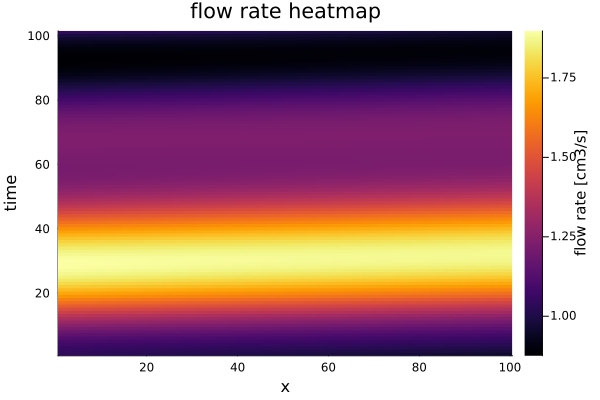

In [5]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


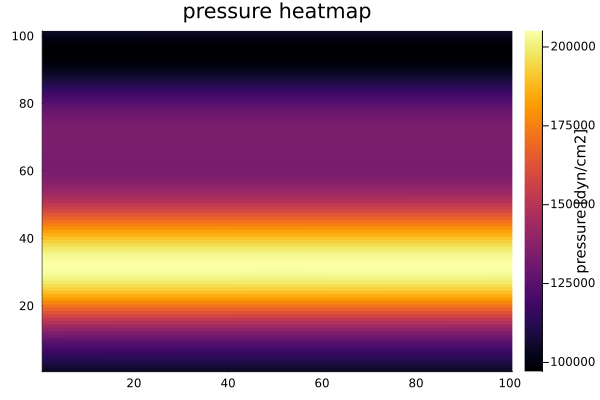

In [6]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [7]:
begin
    global dz = 0.04                     # x step
    global T = 1.0                   # total time
    global L = 3.96                   # total length
    global zspan = (0,L)                 # end points of time integration for ODEProbem
    global dt = 0.01                   #time step
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [8]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [9]:
#first order derivatives
∂t1_center = f1_secondOrder_central(101,dt);
∂t1_forward = f1_secondOrder_forward(101,dt);
∂t1_backward = f1_secondOrder_backward(101,dt);

# use central difference for the majority
∂t1 = ∂t1_center
# use forward and backward difference near the boundaries
∂t1[1,:]=∂t1_forward[1,:]
∂t1[end,:] = ∂t1_backward[end,:]

101-element SparseVector{Float64, Int64} with 3 stored entries:
  [99 ]  =  50.0
  [100]  =  -200.0
  [101]  =  150.0

In [10]:
#waveforms to use
waveforms = 30


# Set the seed for reproducibility
Random.seed!(123)

# # Shuffle the indices of the vector
# shuffled_indices = randperm(size(data1d_fix)[3])

# # Divide the shuffled indices into training and test sets
# train_indices = shuffled_indices[1:waveforms];
# test_indices = shuffled_indices[waveforms+1:end];

# Shuffle the indices of the vector
shuffled_indices = 1:47

# Divide the shuffled indices into training and test sets
train_indices = shuffled_indices[18:end];
test_indices = shuffled_indices[1:17];

In [11]:
# select field variable ID
# 1 - flow rate, 2 - pressure, 3 - area, 4 - Wall Shear Stress
pID = 1

1

In [12]:
#define IC's
u0 = data1d_fix[1,1:end,train_indices,pID];
u01 = data1d_fix[1,1:end,1,pID];

u0_test = data1d_fix[1,1:end,test_indices,pID];

In [13]:
#ground truth data
ytrain2 = data1d_fix[:,1:end,train_indices,pID];
ytrain21 = data1d_fix[:,1:end,1,pID];

ytest2 = data1d_fix[:,1:end,test_indices,pID];

In [14]:
#boundary conditions
bc_flow = data1d_fix[:,1,train_indices,pID];
bc_flow1 = bc_flow[:,1];

bc_flow_test = data1d_fix[:,1,test_indices,pID];

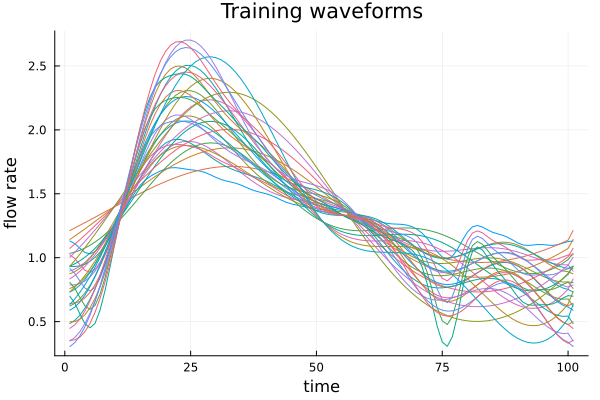

In [15]:
plot(bc_flow, legend = false)
xlabel!("time")
ylabel!("flow rate")
title!("Training waveforms")

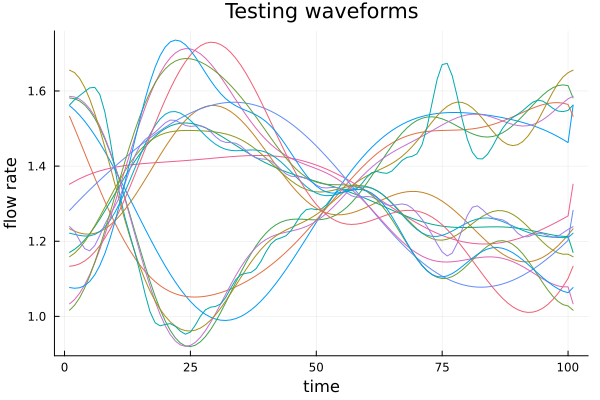

In [16]:
plot(bc_flow_test, legend = false)
xlabel!("time")
ylabel!("flow rate")
title!("Testing waveforms")

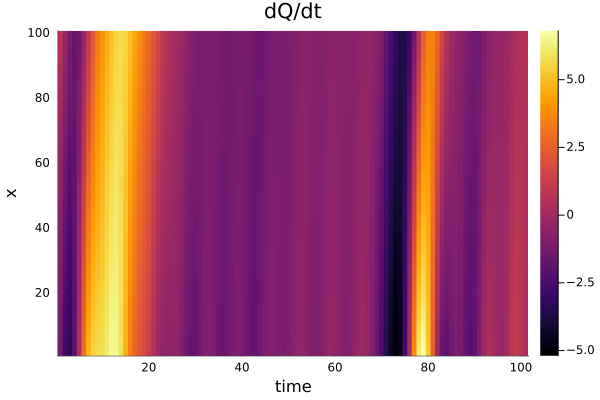

In [17]:
heatmap((∂t1 * ytrain2[:,:,1])')
xlabel!("time")
ylabel!("x")
title!("dQ/dt")

In [18]:
Nspace = size(u01,1)   # number of points in space
x = 0.0 : dz : L        # discretized spatial dimension 

# finite-difference schemes

#first order derivatives
∂x1_center = f1_secondOrder_central(Nspace,dz);
∂x1_forward = f1_secondOrder_forward(Nspace,dz);
∂x1_backward = f1_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(Nspace,dz);
∂x2_forward = f2_secondOrder_forward(Nspace,dz);
∂x2_backward = f2_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

In [19]:
aID = 3
#ground truth data for area
Atrain = data1d_fix[:,1:end,train_indices,aID];
Atrain1 = data1d_fix[:,1:end,1,aID];

Atest = data1d_fix[:,1:end,test_indices,aID];

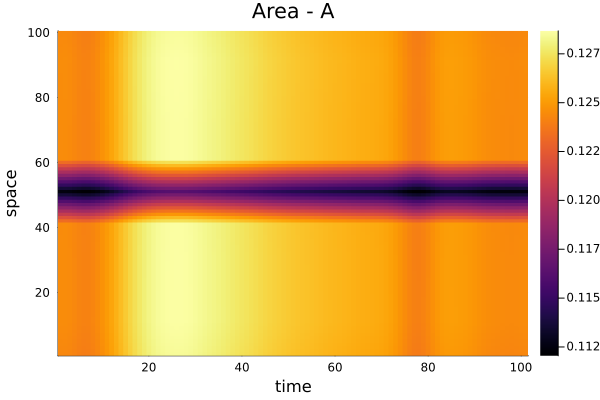

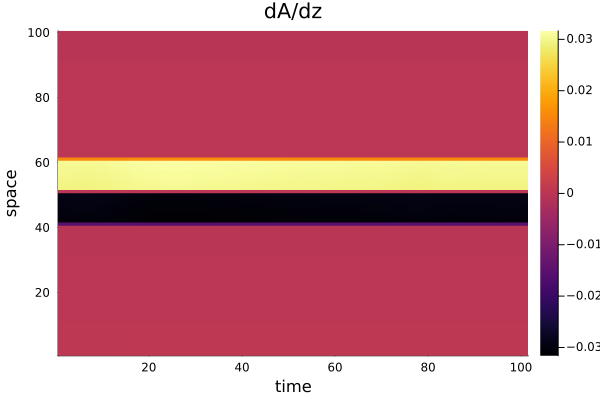

In [20]:
# calculate derivative of area with respect to space
dAdz = zero(Atrain)
dAdz_test = zero(Atest)
for i in 1:size(Atrain)[1]
    dAdz[i,:,:] = ∂x1 * Atrain[i,:,:]
    dAdz_test[i,:,:] = ∂x1 * Atest[i,:,:]
end

#plot area for first simulation/waveform
h1 = heatmap(Atrain[:,:,1]')
xlabel!("time")
ylabel!("space")
title!("Area - A")
display(h1)

heatmap(dAdz[:,:,1]')
xlabel!("time")
ylabel!("space")
title!("dA/dz")

In [21]:
N = size(bc_flow1,1)
# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(101 => 10, tanh),               # 1_020 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 101),                     # 1_111 parameters
)                   # Total: 8 arrays, 2_351 parameters, 9.684 KiB.

In [22]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2351


In [23]:
# # Define time-dependent variables
function interpolate_variables(t, vector)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / dz)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dz) / dz

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == L
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end


# # Define time-dependent boundary condition function
interp_func(z) = interpolate_variables(z, atrain)


interp_func (generic function with 1 method)

In [24]:
# parabolic flow profile constant
# https://simvascular.github.io/docs1DSimulation.html#solver
δ = 1/3;
# viscosity in CGS units
ν = 0.04;
# velocity profile constant
Nprof = -8*π*ν;

In [43]:
function learn_1DBlood(u, p, z, interp_func, dadz_interp_func)
    # u - input to neural network, field variable we are solving for (flow rate)
    # p - neural network parameters
    # z - dependent variable (z -space, or t - time)
    # interp_func - area values for interpolation as a function of z
    # dadz_interp_func - dA/dz values for interpolation as a function of z
    
    
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    

    #concatenate u and the BC as input to the NN
#     input = vcat(u)
    
    # add some physics term to the right-hand-side
    # 1/2*Q/A*dA/dz + N/(2*(1+δ))
    
    #
    #.+ 1/2 .* u ./ interp_func(z) .* dadz_interp_func(z) .+ Nprof/(2*(1+δ))
    #.-1/(2*(1+δ)) .* interp_func(z) ./ u .* (∂t1 * u) 
    return Φ(u) .-1/(2*(1+δ)) .* interp_func(z) ./ u .* (∂t1 * u) #.+ 1/2 .* u ./ interp_func(z) .* dadz_interp_func(z) .+ Nprof/(2*(1+δ))
end

# #define learning problem.
learn_1DBlood_prob(u01,zspan) =  ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, bc_left_func,dadz_interp_func), u01, zspan, p)

learn_1DBlood_prob (generic function with 1 method)

In [51]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/paramBC_testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
# begin 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), bc_flow1, zspan, p)     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dz, saveat=dz, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dz, saveat=dz, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dz, saveat=dz, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
#     println("saved untrained solution")
# end 

prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z,bc_left_func,dadz_interp_func), bc_flow1, zspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff],reltol=1e-20))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff],reltol=1e-20))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff],reltol=1e-20))
    end
end 

predict (generic function with 1 method)

In [52]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)
    
#     dudt = 0.0
    
#     batch = size(ytrain21)[2]
    
#     for i in 1:batch
#         dudt += sum(abs2,repeat(∂t1, outer=(1, 1, batch))[:,:,i] * pred[:,i,:] - repeat(∂t1, outer=(1, 1, batch))[:,:,i] * ytrain21[:,i,:])

#     end
    
    
    
    l = sum(abs2,(pred - ytrain21))# + 0.0*dudt #  + 1e-3*sum(abs.(θ)) #add regularization
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [53]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "ADAM"

"ADAM"

In [54]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is ADAM optimizer
ODE Time integrator selected:Tsit5


In [55]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


In [56]:
L = 3.96  # total length
zspan = (0.0, L)
println(zspan)
tsteps = 0:dz:zspan[2]  # create time vector

n_epochs = 5
#set batch size
batch_size = 5
println("Batch size:", batch_size)
#training batches
batch_iterations = Int(size(ytrain2,3)/batch_size)
#testing batches
test_batch_iterations = Int(ceil(size(ytest2,3)/batch_size));

(0.0, 3.96)
Batch size:5


In [57]:
list_loss_train = []
list_loss_epoch = []
list_loss_test = []
list_loss_epoch_test = []
for j in 1:n_epochs
    println("Start training epoch ",j)
    loss_tot = 0.0
    loss_tot_test = 0.0
            # loop over different waveforms
            for i in 1:batch_iterations
                
                println("waveform batch: ",i, "/",batch_iterations)
                flush(stdout)
                #reorder ytrain, atrain and dAdz to [time, batch_size, spatial location]
                # batch size should be second column
                ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                dadztrain = permutedims(dAdz[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                
                
                #define function for interpolating area and dA/dz to the actual spatial location for the ODE
                interp_func(z) = interpolate_variables(z, atrain)
                dadz_interp_func(z) = interpolate_variables(z, dadztrain)
            
                #define optimization problem
                prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, interp_func,dadz_interp_func), ytrain[:,:,1], zspan, p);
                optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain[:,:,:],prob),adtype) ;

                println("Using $optimizer_choice1 optimizer")
                println("Sum of params:", sum(uinit))

                # Change learning rate for ADAM optimizer, BFGS doesn't use it
                if j == 2
                    learning_rate = 0.0001
                    println("Changing learning rate to:",learning_rate)
                end

                uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
                println("Sum of params:", sum(uinit))

                if !isnothing(optimizer_choice2)
                    println("Switching to $optimizer_choice2 optimizer")

                    uinit = train_loop(uinit,adtype,optf,train_maxiters*1,learning_rate,optimizer_choice2)

                    println("Sum of params:", sum(uinit))

                end


                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, interp_func,dadz_interp_func), ytrain[:,:,1], zspan, p);
                l , pred = loss(uinit,ytrain[:,:,:],prob)
                loss_tot = loss_tot + l

                push!(list_loss_train, l)
                
        
                #calculate derivative error
                dudt = 0.0
                batch = size(ytrain)[2]
                #sum error across all samples in the batch
                for i in 1:batch
                    dudt +=sum(abs2,repeat(∂t1, outer=(1, 1, batch))[:,:,i] * pred[:,i,:] - repeat(∂t1, outer=(1, 1, batch))[:,:,i] * ytrain[:,i,:])
                end
                println("Train du/dt error:",dudt)
                # plot solution for comparison
                plot1 = heatmap(pred[:,1,:]', color=:viridis, title = "neural ODE flow rate")
                xlabel!("time")
                ylabel!("x")

                plot2 = heatmap(ytrain[:,1,:]', title="1D - flow rate", color=:viridis)
                xlabel!("time")
                ylabel!("x")
                display(plot(plot1,plot2,layout = (2, 1)))
                sleep(1)
        
        
                # plot solution for comparison
                plot1 = heatmap((repeat(∂t1, outer=(1, 1, batch))[:,:,1] * pred[:,1,:])', color=:viridis, title = "neural ODE dQ/dt")
                xlabel!("time")
                ylabel!("x")

                plot2 = heatmap((repeat(∂t1, outer=(1, 1, batch))[:,:,1] * ytrain[:,1,:])', title="1D - dQ/dt", color=:viridis)
                xlabel!("time")
                ylabel!("x")
                display(plot(plot1,plot2,layout = (2, 1)))
                sleep(1)
            end    
    
            #testing loop
            println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
            println("Testing:")

            for i in 1:test_batch_iterations

                println("waveform batch: ",i, "/",test_batch_iterations)

                #reorder ytrain to (spatial location, batch_size, time)
                if i!=test_batch_iterations
                    ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                    atest = permutedims(Atest[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                    dadztest = permutedims(dAdz_test[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
                else
                    ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:end],(1,3,2))
                    atest = permutedims(Atest[:,:,batch_size*(i-1)+1:end],(1,3,2))
                    dadztest = permutedims(dAdz_test[:,:,batch_size*(i-1)+1:end],(1,3,2))
                end

        
                #define function for interpolating area and dA/dz to the actual spatial location for the ODE
                interp_func(z) = interpolate_variables(z, atest)
                dadz_interp_func(z) = interpolate_variables(z, dadztest)


                #calculate final loss and push it to the list
                prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func,dadz_interp_func), ytest[:,:,1], zspan, p);
                l , pred = loss(uinit,ytest[:,:,:],prob)
                loss_tot_test = loss_tot_test + l

                push!(list_loss_test, l)
                println("Test loss:",l )
        
                #calculate derivative error
                dudt = 0.0
                batch = size(ytest)[2]
                #sum error across all samples in the batch
                for i in 1:batch
                    dudt +=sum(abs2,repeat(∂t1, outer=(1, 1, batch))[:,:,i] * pred[:,i,:] - repeat(∂t1, outer=(1, 1, batch))[:,:,i] * ytest[:,i,:])
                end
        
                println("Test du/dt error:",dudt)
                # plot solution for comparison
                plot1 = heatmap(pred[:,1,:]', color=:viridis, title = "neural ODE flow rate")
                xlabel!("time")
                ylabel!("x")

                plot2 = heatmap(ytest[:,1,:]', title="1D - flow rate", color=:viridis)
                xlabel!("time")
                ylabel!("x")
                display(plot(plot1,plot2,layout = (2, 1)))
                sleep(1)
            end


push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
push!(list_loss_epoch_test, loss_tot_test/(size(ytest2,3)))
println("Epoch ", j, " mean train loss:", loss_tot/(size(ytrain2,3)))
println("Epoch ", j, " mean test loss:", loss_tot_test/(size(ytest2,3)))
end

Start training epoch 1
waveform batch: 1/6
Using ADAM optimizer
Sum of params:-1.595572
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 8052.359368709668
Iteration: 2 || Loss: 29513.555829842328


┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606


Iteration: 3 || Loss: 35859.9557138679


┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: Endpoints do not match. Return code: Unstable. Likely your time range is not a multiple of `saveat`. sol.t[end]: 0.004, ts[end]: 3.96
└ @ DiffEqSensitivity ~/.julia/packages/DiffEqSensitivity/Pn9H4/src/concrete_solve.jl:952


LoadError: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(101), Base.OneTo(5), Base.OneTo(101)), b has dims (Base.OneTo(101), Base.OneTo(5), Base.OneTo(100)), mismatch at 3

In [58]:
# plot loss as a function of epochs
p3 = plot([list_loss_epoch,list_loss_epoch_test], yaxis=:log, label = ["train" "test"])
ylabel!("loss")
xlabel!("epochs")
png("dQdz_wdudt_loss_1DBlood_loss.png")
display(p3)

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


### Load the final learnt parameters and do inference for the test set ###

In [34]:
# p_learn = load("/home/tschala/research/LANL/paramBC_testNODE/ptrained_"*optimizer_choice2*".jld2")
# #load parameters
# p = p_learn["p"]
# println(sum(p))
# # loop through the test set
# for i in 1:17
#     u01 = bc_flow_test[:,i]
#     L = 3.96                      # total length
#     tsteps = 0.0:dz:L             # discretized space dimension
#     tspan = (0,L)    

#     begin 
#         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t,), u01, zspan, p)     # p changes after training   
#         if ode_solver == "Tsit5"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,zspan),Tsit5(),alg_hints=[:stiff], dt=dz, saveat=dz, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "RK4"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,zspan),RK4(),alg_hints=[:stiff], dt=dz, saveat=dz, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         elseif ode_solver == "Rosenbrock23"
#             sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,zspan),Rosenbrock23(),alg_hints=[:stiff], dt=dz, saveat=dz, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#         end
#         save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#         println("saved trained solution")
#     end

#     sol_learn = load("/home/tschala/research/LANL/paramBC_testNODE/output/sol_learn_testNODE_trained.jld2");

#     plot1 = heatmap(sol_learn["single_stored_object"][:,:]', color=:viridis, title = "neural ODE flow rate")
#     xlabel!("time")
#     ylabel!("x")

#     plot2 = heatmap(ytest2[:,:,i]', title="1D - flow rate", color=:viridis)
#     xlabel!("time")
#     ylabel!("x")

#     display(plot(plot1,plot2,layout = (2, 1)))
#     sleep(1)
# end